In [3]:
import numpy as np
import pandas as pd 
import os
import matplotlib.pyplot as plt
import cv2
from tqdm import tqdm


import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import transforms
import torch.nn as nn
from torch.nn import functional as F
from torch.autograd import Variable

KeyboardInterrupt: 

In [3]:
TRAIN_DIR = "./train"
VALID_DIR = "./valid"
TEST_DIR = "./test"
COLOR_CODES = "./class_dict.csv"

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((256, 256)),
])

In [5]:
df = pd.read_csv(COLOR_CODES)
label_map = {}
for index, row in df.iterrows():
    label_map[index] = [row["r"],row["g"],row["b"]]
label_map

{0: [0, 255, 255],
 1: [255, 255, 0],
 2: [255, 0, 255],
 3: [0, 255, 0],
 4: [0, 0, 255],
 5: [255, 255, 255],
 6: [0, 0, 0]}

In [7]:
class Segmentation_Dataset(Dataset):
    def __init__(self, image_dir, label_map, transform):
        self.image_dir = image_dir
        self.transform = transform
        self.label_map = label_map
        self.images_name = sorted([filename for filename in os.listdir(self.image_dir) if filename.endswith('_sat.jpg')])
        self.targets_name = sorted([filename for filename in os.listdir(self.image_dir) if filename.endswith('_mask.png')])
        
    def __len__(self):
        return len(self.images_name)

    def __getitem__(self, idx):
        image_path = os.path.join(self.image_dir, self.images_name[idx])
        mask_path = os.path.join(self.image_dir, self.targets_name[idx])
        
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # convert RGB
        
        mask = cv2.imread(mask_path)
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
        mask = self.colormap_to_labelmap(mask)
        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)
            
        return image, mask
    
    def colormap_to_labelmap(self, mask):
        label_image = np.zeros_like(mask[:,:,0], dtype=np.uint8)

        for label, color in self.label_map.items():
            color_array = np.array(color)
            mask_condition = np.all(mask == color_array, axis=-1)
            label_image[mask_condition] = label

        return label_image.astype(np.float32)

In [9]:
class ResidualBlock(nn.Module):
    def __init__(self, in_c=3, out_c=1):
        super(ResidualBlock, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_c, out_c, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(out_c),
            nn.LeakyReLU(negative_slope=0.1, inplace=True),
            nn.Conv2d(out_c, out_c, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(out_c),
            nn.LeakyReLU(negative_slope=0.1, inplace=True)
        )
        self.skip = nn.Sequential(
            nn.Conv2d(in_c, out_c, kernel_size=1, stride=1, padding=0),
            nn.BatchNorm2d(out_c),
            nn.LeakyReLU(negative_slope=0.1, inplace=True)
        )

    def forward(self, x):
        conv = self.conv(x)
        skip = self.skip(x)

        plus = conv + skip
        return plus

class UNet(nn.Module):

    def __init__(self, n_class):
        super().__init__()
                
        self.dconv_down1 = ResidualBlock(3, 64)
        self.dconv_down2 = ResidualBlock(64, 128)
        self.dconv_down3 = ResidualBlock(128, 256)
        self.dconv_down4 = ResidualBlock(256,512)
        self.bottleneck = ResidualBlock(512, 1024)        

        self.maxpool = nn.MaxPool2d(2)

        self.dconv1 =  nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)        
        self.dconv2 =  nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.dconv3 =  nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.dconv4 =  nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)

        self.dconv_up4 = ResidualBlock(1024, 512) 
        self.dconv_up3 = ResidualBlock(512, 256)
        self.dconv_up2 = ResidualBlock(256, 128)
        self.dconv_up1 = ResidualBlock(128, 64)
        self.conv_last = nn.Conv2d(64, n_class, 1)
        
        
    def forward(self, x):

        # encoder
        conv1 = self.dconv_down1(x)
        x1 = self.maxpool(conv1) 

        conv2 = self.dconv_down2(x1)
        x2 = self.maxpool(conv2) 
        
        conv3 = self.dconv_down3(x2)
        x3 = self.maxpool(conv3) 

        conv4 = self.dconv_down4(x3)
        x4 = self.maxpool(conv4)         

        x5 = self.bottleneck(x4) 


        x = self.dconv1(x5)        
        x = torch.cat([x, conv4], dim=1)
        x = self.dconv_up4(x)

        x = self.dconv2(x)        
        x = torch.cat([x, conv3], dim=1)       
        x = self.dconv_up3(x)

        x = self.dconv3(x)        
        x = torch.cat([x, conv2], dim=1)   
        x = self.dconv_up2(x)

        x = self.dconv4(x)        
        x = torch.cat([x, conv1], dim=1)   
        x = self.dconv_up1(x)
        
        seg = self.conv_last(x)

        return seg

In [11]:
class FocalLoss(nn.Module):
    def __init__(self, gamma=0, alpha=None, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.reduction = reduction
        self.gamma = gamma
        self.alpha = alpha
        if isinstance(alpha, (float, int, torch.LongTensor)): self.alpha = torch.Tensor([alpha, 1 - alpha])
        if isinstance(alpha, list): self.alpha = torch.Tensor(alpha)

    def forward(self, input, target):
        if input.dim() > 2:
            input = input.view(input.size(0), input.size(1), -1)  # N,C,H,W => N,C,H*W
            input = input.transpose(1, 2)  # N,C,H*W => N,H*W,C
            input = input.contiguous().view(-1, input.size(2))  # N,H*W,C => N*H*W,C
        target = target.view(-1, 1)

        logpt = F.log_softmax(input)
        logpt = logpt.gather(1, target)
        logpt = logpt.view(-1)
        pt = Variable(logpt.data.exp())

        if self.alpha is not None:
            if self.alpha.type() != input.data.type():
                self.alpha = self.alpha.type_as(input.data)
            at = self.alpha.gather(0, target.data.view(-1))
            logpt = logpt * Variable(at)

        loss = -1 * (1 - pt) ** self.gamma * logpt
        if self.reduction == "none":
            return loss
        elif self.reduction == "mean":
            return loss.mean()
        elif self.reduction == "sum":
            return loss.sum()

In [13]:
from tqdm import tqdm

class Train:
    def __init__(self, model, dataloader, optimizer, num_epoch, device, loss):
        self.model = model
        self.dataloader = dataloader
        self.optimizer = optimizer
        self.num_epoch = num_epoch  # Ensure attribute name matches
        self.device = device
        self.loss = loss

    def train(self):
        self.model.to(self.device)
        self.model.train()
        for epoch in range(self.num_epoch):  # Use self.num_epoch here
            total_loss = 0.0
            total_samples = 0
            with tqdm(self.dataloader, unit="batch") as dl:
                for inputs, labels in dl:
                    inputs, labels = inputs.to(self.device), labels.to(self.device)
                    predictions = self.model(inputs)
                    labels = labels.squeeze().long()
                    loss = self.loss(predictions, labels)
                    self.optimizer.zero_grad()
                    loss.backward()
                    self.optimizer.step()
                    total_loss += loss.item() * inputs.size(0)
                    total_samples += inputs.size(0)
                    dl.set_postfix({"Epoch": epoch + 1, "Loss": total_loss / total_samples})
            epoch_loss = total_loss / total_samples
            print(f"Epoch [{epoch + 1}/{self.num_epoch}], Loss: {epoch_loss:.4f}")  # Corrected attribute name


In [15]:
num_classes = len(label_map.keys())
lr = 0.001
batch_size = 4
model = UNet(n_class=num_classes)
train_dataset = Segmentation_Dataset(TRAIN_DIR, label_map, transform)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
optimizer = torch.optim.AdamW(model.parameters(), lr)
num_epochs = 50
device =  torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
loss = FocalLoss()

# Check if CUDA is available
if torch.cuda.is_available():
    print("CUDA is available. You have a GPU.")
    print(f"Number of GPUs: {torch.cuda.device_count()}")
    print(f"Current GPU: {torch.cuda.get_device_name(torch.cuda.current_device())}")
else:
    print("CUDA is not available. You are using the CPU.")


CUDA is not available. You are using the CPU.


In [64]:
trainer = Train(model, train_dataloader, optimizer, num_epochs, device, loss)
trainer.train()

  0%|          | 0/201 [00:00<?, ?batch/s]C:\Users\Saurav\AppData\Local\Temp\ipykernel_18484\93752488.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  logpt = F.log_softmax(input)
100%|██████████| 201/201 [21:51<00:00,  6.52s/batch, Epoch=1, Loss=1.18]


Epoch [1/50], Loss: 1.1801


100%|██████████| 201/201 [21:14<00:00,  6.34s/batch, Epoch=2, Loss=1.01]


Epoch [2/50], Loss: 1.0126


100%|██████████| 201/201 [25:09<00:00,  7.51s/batch, Epoch=3, Loss=0.946]


Epoch [3/50], Loss: 0.9456


100%|██████████| 201/201 [21:28<00:00,  6.41s/batch, Epoch=4, Loss=0.898]


Epoch [4/50], Loss: 0.8984


100%|██████████| 201/201 [8:33:42<00:00, 153.34s/batch, Epoch=5, Loss=0.85]     


Epoch [5/50], Loss: 0.8498


100%|██████████| 201/201 [26:06<00:00,  7.79s/batch, Epoch=6, Loss=0.8]  


Epoch [6/50], Loss: 0.8003


100%|██████████| 201/201 [26:41<00:00,  7.97s/batch, Epoch=7, Loss=0.782]


Epoch [7/50], Loss: 0.7820


100%|██████████| 201/201 [21:18<00:00,  6.36s/batch, Epoch=8, Loss=0.762]


Epoch [8/50], Loss: 0.7618


100%|██████████| 201/201 [21:28<00:00,  6.41s/batch, Epoch=9, Loss=0.761]


Epoch [9/50], Loss: 0.7613


100%|██████████| 201/201 [2:19:45<00:00, 41.72s/batch, Epoch=10, Loss=0.718]    


Epoch [10/50], Loss: 0.7184


100%|██████████| 201/201 [21:24<00:00,  6.39s/batch, Epoch=11, Loss=0.713]


Epoch [11/50], Loss: 0.7135


100%|██████████| 201/201 [21:22<00:00,  6.38s/batch, Epoch=12, Loss=0.704]


Epoch [12/50], Loss: 0.7037


100%|██████████| 201/201 [21:24<00:00,  6.39s/batch, Epoch=13, Loss=0.693]


Epoch [13/50], Loss: 0.6932


100%|██████████| 201/201 [21:15<00:00,  6.34s/batch, Epoch=14, Loss=0.674]


Epoch [14/50], Loss: 0.6744


100%|██████████| 201/201 [21:57<00:00,  6.56s/batch, Epoch=15, Loss=0.668]


Epoch [15/50], Loss: 0.6683


100%|██████████| 201/201 [1:14:18<00:00, 22.18s/batch, Epoch=16, Loss=0.657] 


Epoch [16/50], Loss: 0.6574


100%|██████████| 201/201 [21:37<00:00,  6.45s/batch, Epoch=17, Loss=0.649]


Epoch [17/50], Loss: 0.6493


100%|██████████| 201/201 [21:35<00:00,  6.44s/batch, Epoch=18, Loss=0.613]


Epoch [18/50], Loss: 0.6132


100%|██████████| 201/201 [21:43<00:00,  6.49s/batch, Epoch=19, Loss=0.609]


Epoch [19/50], Loss: 0.6094


100%|██████████| 201/201 [21:37<00:00,  6.46s/batch, Epoch=20, Loss=0.631]


Epoch [20/50], Loss: 0.6310


100%|██████████| 201/201 [21:39<00:00,  6.46s/batch, Epoch=21, Loss=0.621]


Epoch [21/50], Loss: 0.6207


100%|██████████| 201/201 [21:35<00:00,  6.45s/batch, Epoch=22, Loss=0.621]


Epoch [22/50], Loss: 0.6210


100%|██████████| 201/201 [21:57<00:00,  6.56s/batch, Epoch=23, Loss=0.601]


Epoch [23/50], Loss: 0.6006


100%|██████████| 201/201 [21:34<00:00,  6.44s/batch, Epoch=24, Loss=0.61] 


Epoch [24/50], Loss: 0.6102


100%|██████████| 201/201 [21:40<00:00,  6.47s/batch, Epoch=25, Loss=0.582]


Epoch [25/50], Loss: 0.5816


100%|██████████| 201/201 [21:35<00:00,  6.44s/batch, Epoch=26, Loss=0.572]


Epoch [26/50], Loss: 0.5719


100%|██████████| 201/201 [21:27<00:00,  6.41s/batch, Epoch=27, Loss=0.583]


Epoch [27/50], Loss: 0.5825


100%|██████████| 201/201 [20:52<00:00,  6.23s/batch, Epoch=28, Loss=0.586]


Epoch [28/50], Loss: 0.5859


100%|██████████| 201/201 [20:42<00:00,  6.18s/batch, Epoch=29, Loss=0.561]


Epoch [29/50], Loss: 0.5606


100%|██████████| 201/201 [20:43<00:00,  6.19s/batch, Epoch=30, Loss=0.563]


Epoch [30/50], Loss: 0.5629


100%|██████████| 201/201 [20:50<00:00,  6.22s/batch, Epoch=31, Loss=0.544]


Epoch [31/50], Loss: 0.5437


100%|██████████| 201/201 [30:40<00:00,  9.16s/batch, Epoch=32, Loss=0.559] 


Epoch [32/50], Loss: 0.5588


100%|██████████| 201/201 [21:17<00:00,  6.35s/batch, Epoch=33, Loss=0.57] 


Epoch [33/50], Loss: 0.5701


100%|██████████| 201/201 [21:15<00:00,  6.35s/batch, Epoch=34, Loss=0.559]


Epoch [34/50], Loss: 0.5592


100%|██████████| 201/201 [21:21<00:00,  6.37s/batch, Epoch=35, Loss=0.549]


Epoch [35/50], Loss: 0.5489


100%|██████████| 201/201 [21:18<00:00,  6.36s/batch, Epoch=36, Loss=0.568]


Epoch [36/50], Loss: 0.5685


100%|██████████| 201/201 [21:19<00:00,  6.37s/batch, Epoch=37, Loss=0.54] 


Epoch [37/50], Loss: 0.5399


100%|██████████| 201/201 [21:14<00:00,  6.34s/batch, Epoch=38, Loss=0.527]


Epoch [38/50], Loss: 0.5269


100%|██████████| 201/201 [21:16<00:00,  6.35s/batch, Epoch=39, Loss=0.531]


Epoch [39/50], Loss: 0.5308


100%|██████████| 201/201 [21:15<00:00,  6.34s/batch, Epoch=40, Loss=0.514]


Epoch [40/50], Loss: 0.5145


100%|██████████| 201/201 [21:14<00:00,  6.34s/batch, Epoch=41, Loss=0.506]


Epoch [41/50], Loss: 0.5063


100%|██████████| 201/201 [21:14<00:00,  6.34s/batch, Epoch=42, Loss=0.498]


Epoch [42/50], Loss: 0.4978


100%|██████████| 201/201 [21:15<00:00,  6.34s/batch, Epoch=43, Loss=0.492]


Epoch [43/50], Loss: 0.4919


100%|██████████| 201/201 [21:21<00:00,  6.37s/batch, Epoch=44, Loss=0.506]


Epoch [44/50], Loss: 0.5059


100%|██████████| 201/201 [21:49<00:00,  6.52s/batch, Epoch=45, Loss=0.52] 


Epoch [45/50], Loss: 0.5204


100%|██████████| 201/201 [22:13<00:00,  6.63s/batch, Epoch=46, Loss=0.515]


Epoch [46/50], Loss: 0.5152


100%|██████████| 201/201 [22:16<00:00,  6.65s/batch, Epoch=47, Loss=0.483]


Epoch [47/50], Loss: 0.4834


100%|██████████| 201/201 [22:18<00:00,  6.66s/batch, Epoch=48, Loss=0.491]


Epoch [48/50], Loss: 0.4913


100%|██████████| 201/201 [22:19<00:00,  6.66s/batch, Epoch=49, Loss=0.476]


Epoch [49/50], Loss: 0.4757


100%|██████████| 201/201 [22:16<00:00,  6.65s/batch, Epoch=50, Loss=0.471]

Epoch [50/50], Loss: 0.4711


In [66]:
torch.save(model.state_dict(), 'full_model.pth')
model.load_state_dict(torch.load('full_model.pth'))
model.to(device)
model.eval()

C:\Users\Saurav\AppData\Local\Temp\ipykernel_18484\2906269004.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('full_model.pth'))


UNet(
  (dconv_down1): ResidualBlock(
    (conv): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.1, inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): LeakyReLU(negative_slope=0.1, inplace=True)
    )
    (skip): Sequential(
      (0): Conv2d(3, 64, kernel_size=(1, 1), stride=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.1, inplace=True)
    )
  )
  (dconv_down2): ResidualBlock(
    (conv): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(

tensor([0, 1, 2, 3, 4, 5, 6])


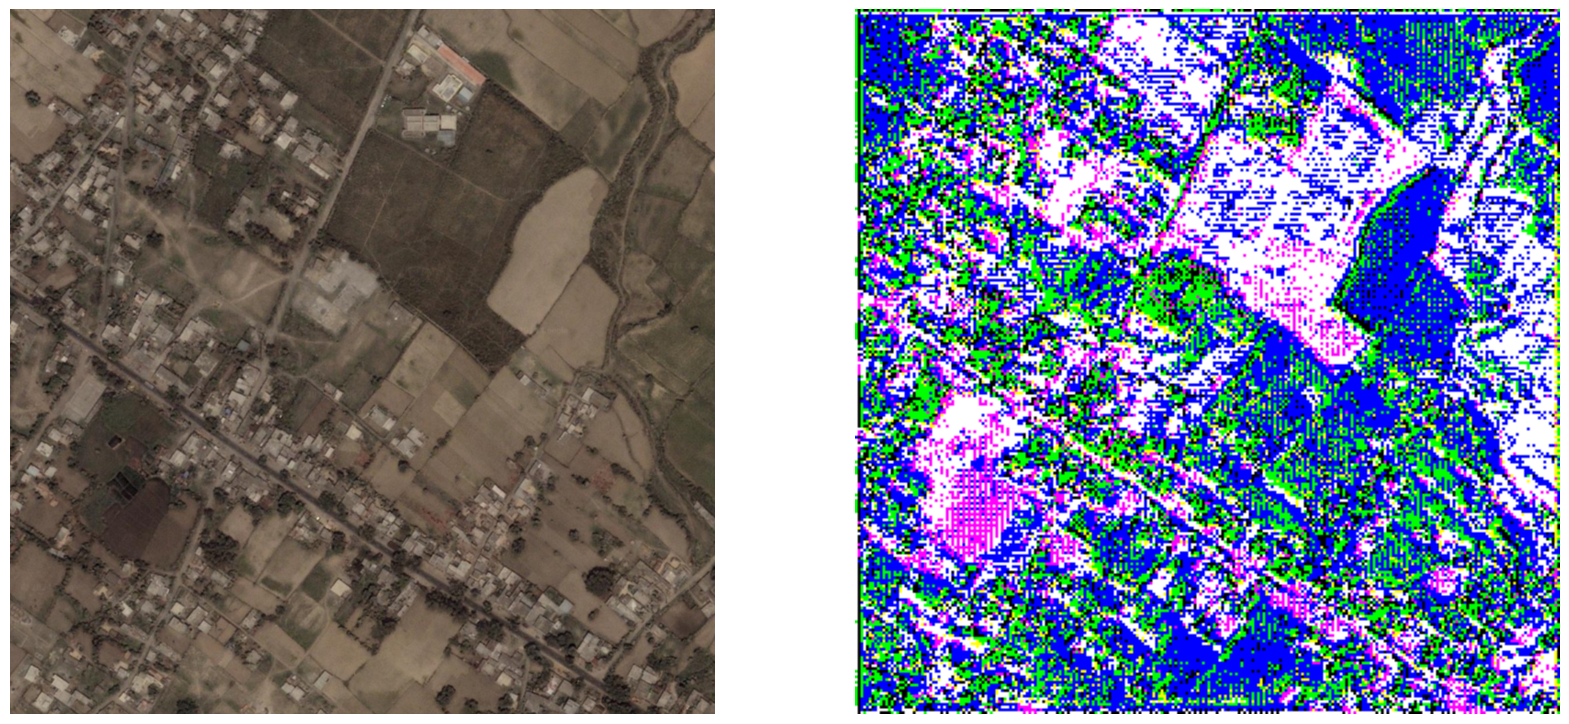

In [17]:
import cv2
img = cv2.imread(r"C:\Users\Saurav\Documents\predictive analytics project\New folder\ChangePrediction\src\change_prediction_images\before\dehradhun_2012_2.jpeg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
input_tensor = transform(img)
input_batch = input_tensor.unsqueeze(0).to(device)

with torch.no_grad():
    output = model(input_batch).squeeze()

_, predicted_labels = torch.max(output, 0)
predicted_mask = predicted_labels.squeeze().cpu().numpy()
print(torch.unique(predicted_labels))

label_map_colors = {0: [0, 255, 255],
 1: [255, 255, 0],
 2: [255, 0, 255],
 3: [0, 255, 0],
 4: [0, 0, 255],
 5: [255, 255, 255],
 6: [0, 0, 0]}

Before = np.zeros((predicted_mask.shape[0], predicted_mask.shape[1], 3), dtype=np.uint8)
for label, color in label_map_colors.items():
    Before[predicted_mask == label] = color

plt.figure(figsize =(20,10))
plt.subplot(1, 2, 1)
plt.imshow(img)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(Before)
plt.axis('off')

plt.show()





tensor([0, 1, 2, 3, 4, 5, 6])


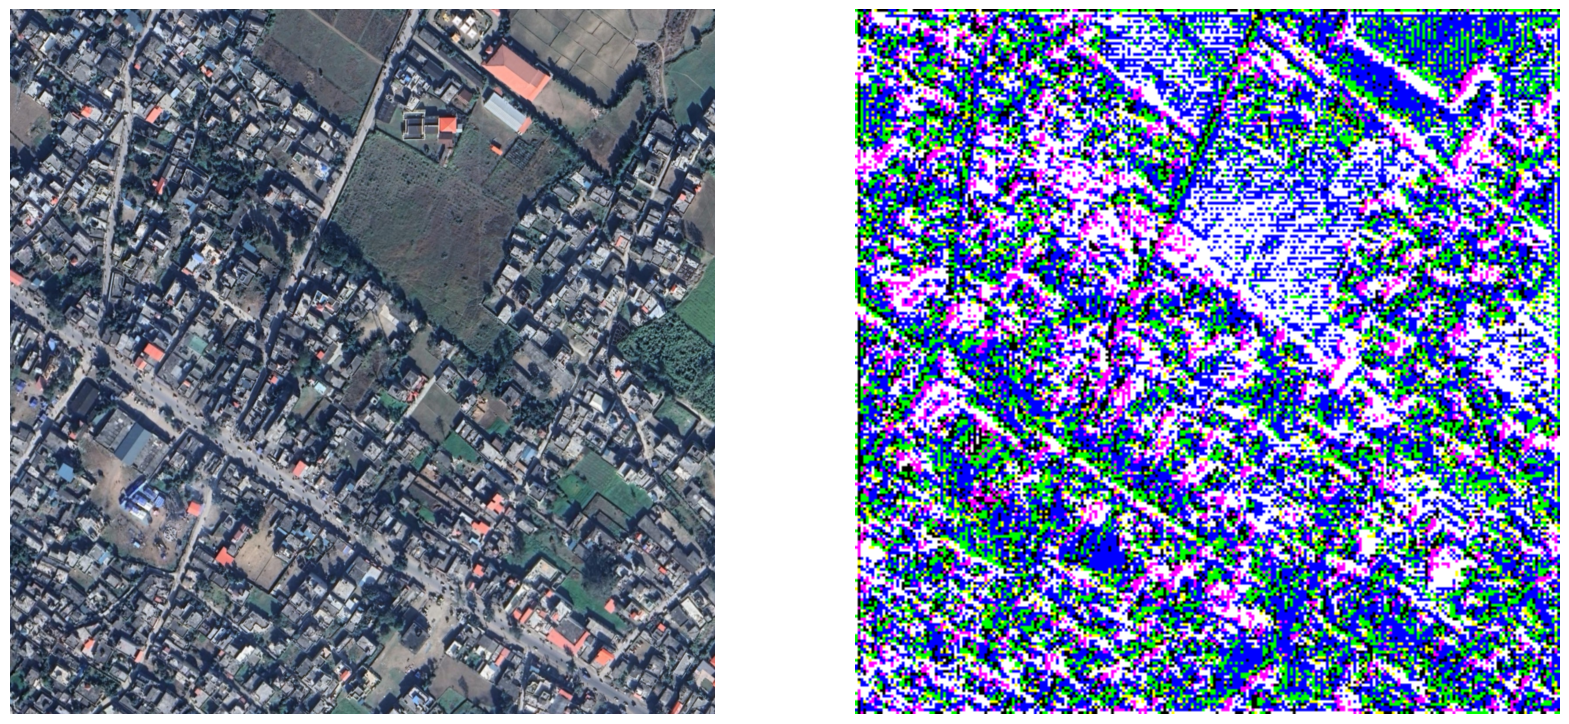

In [49]:
img = cv2.imread(r"C:\Users\Saurav\Documents\predictive analytics project\New folder\ChangePrediction\src\change_prediction_images\after\dehradhun_2024_2.jpeg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
input_tensor = transform(img)
input_batch = input_tensor.unsqueeze(0).to(device)

with torch.no_grad():
    output = model(input_batch).squeeze()

_, predicted_labels = torch.max(output, 0)
predicted_mask = predicted_labels.squeeze().cpu().numpy()
print(torch.unique(predicted_labels))

label_map_colors = {0: [0, 255, 255],
 1: [255, 255, 0],
 2: [255, 0, 255],
 3: [0, 255, 0],
 4: [0, 0, 255],
 5: [255, 255, 255],
 6: [0, 0, 0]}

colored_mask = np.zeros((predicted_mask.shape[0], predicted_mask.shape[1], 3), dtype=np.uint8)
for label, color in label_map_colors.items():
    colored_mask[predicted_mask == label] = color

plt.figure(figsize =(20,10))
plt.subplot(1, 2, 1)
plt.imshow(img)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(colored_mask)
plt.axis('off')

plt.show()





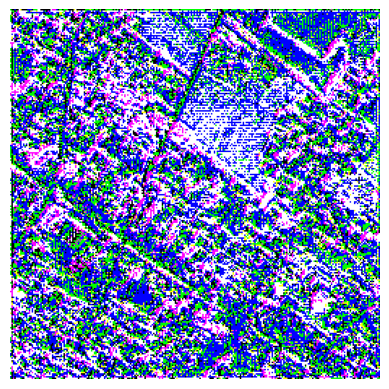

Colored mask saved at: C:\Users\Saurav\Documents\predictive analytics project\New folder\ChangePrediction\src\change_prediction_images\after\dehradhun_2024_2_mask.jpeg


In [23]:
#After
plt.imshow(colored_mask)
plt.axis('off')
save_path = r"C:\Users\Saurav\Documents\predictive analytics project\New folder\ChangePrediction\src\change_prediction_images\after\dehradhun_2024_2_mask.jpeg"
plt.savefig(save_path,bbox_inches='tight')
plt.show()
print(f"Colored mask saved at: {save_path}")



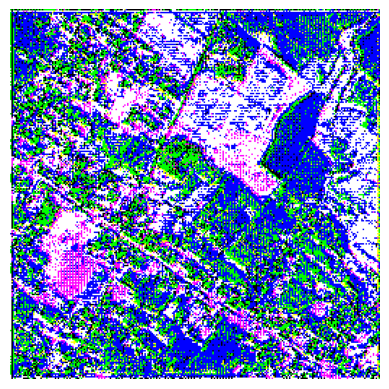

Colored mask saved at: C:\Users\Saurav\Documents\predictive analytics project\New folder\ChangePrediction\src\change_prediction_images\before\dehradhun_2012_2_mask.jpeg


In [25]:
#before
plt.imshow(Before)
plt.axis('off')
save_path = r"C:\Users\Saurav\Documents\predictive analytics project\New folder\ChangePrediction\src\change_prediction_images\before\dehradhun_2012_2_mask.jpeg"
plt.savefig(save_path,bbox_inches='tight')
plt.show()
print(f"Colored mask saved at: {save_path}")

In [1]:
# Load the two mask images (grayscale)
mask1 = cv2.imread(r"C:\Users\Saurav\Documents\predictive analytics project\New folder\ChangePrediction\src\change_prediction_images\before\dehradhun_2012_2_mask.jpeg", cv2.IMREAD_GRAYSCALE)
mask2 = cv2.imread(r"C:\Users\Saurav\Documents\predictive analytics project\New folder\ChangePrediction\src\change_prediction_images\after\dehradhun_2024_2_mask.jpeg", cv2.IMREAD_GRAYSCALE)


# Ensure both masks are the same shape
if mask1.shape != mask2.shape:
    raise ValueError("The two masks must have the same dimensions")

# Calculate the change mask
change_mask = np.where(mask1 != mask2, 1, 0)  # 1 for changed pixels, 0 for unchanged

# Calculate the percentage of change
total_pixels = change_mask.size
changed_pixels = np.sum(change_mask)
change_percentage = (changed_pixels / total_pixels) * 100

print(f"Percentage of change between masks: {change_percentage:.2f}%")

# Visualize the change mask
plt.figure(figsize=(10, 10))
plt.imshow(change_mask, cmap="gray")
plt.title(f"Change Mask - {change_percentage:.2f}% changed")
plt.axis("off")

# # Save the change mask
# output_path = r"path_to_save_change_mask.jpeg"
# plt.savefig(output_path, bbox_inches='tight', pad_inches=0)
plt.show()


NameError: name 'cv2' is not defined

Percentage of change between masks: 8.55%


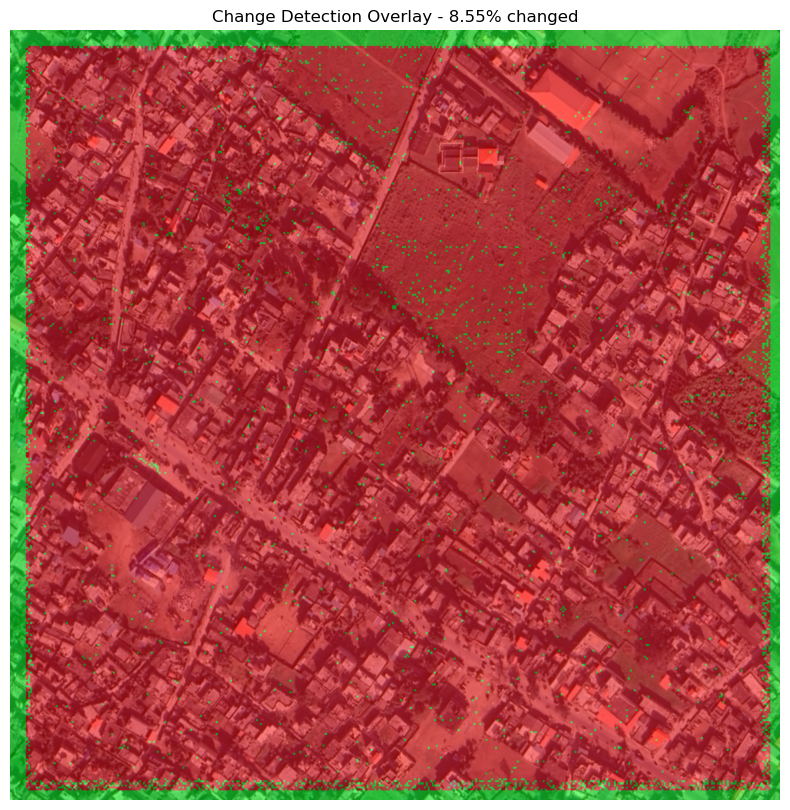

In [57]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Load the two mask images (grayscale)
mask1 = cv2.imread(r"C:\Users\Saurav\Documents\predictive analytics project\New folder\ChangePrediction\src\change_prediction_images\before\dehradhun_2012_2_mask.jpeg", cv2.IMREAD_GRAYSCALE)
mask2 = cv2.imread(r"C:\Users\Saurav\Documents\predictive analytics project\New folder\ChangePrediction\src\change_prediction_images\after\dehradhun_2024_2_mask.jpeg", cv2.IMREAD_GRAYSCALE)

# Load the original image (after image for displaying the overlay)
original_image = cv2.imread(r"C:\Users\Saurav\Documents\predictive analytics project\New folder\ChangePrediction\src\change_prediction_images\after\dehradhun_2024_2.jpeg")
original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)

# Resize masks to match the dimensions of the original image if needed
if mask1.shape != original_image.shape[:2]:
    mask1 = cv2.resize(mask1, (original_image.shape[1], original_image.shape[0]), interpolation=cv2.INTER_NEAREST)
if mask2.shape != original_image.shape[:2]:
    mask2 = cv2.resize(mask2, (original_image.shape[1], original_image.shape[0]), interpolation=cv2.INTER_NEAREST)

# Calculate the change mask (1 for changed pixels, 0 for unchanged)
change_mask = np.where(mask1 != mask2, 1, 0)

# Create an overlay image, initially setting unchanged areas to green and changed areas to red
overlay = np.zeros_like(original_image)
overlay[change_mask == 1] = [255, 0, 0]  # Red for changed areas
overlay[change_mask == 0] = [0, 255, 0]  # Green for unchanged areas

# Blend the overlay with the original image (for a semi-transparent effect)
alpha = 0.5  # Transparency factor
output_image = cv2.addWeighted(overlay, alpha, original_image, 1 - alpha, 0)

# Calculate the percentage of change
total_pixels = change_mask.size
changed_pixels = np.sum(change_mask)
change_percentage = 100 - (changed_pixels / total_pixels) * 100
print(f"Percentage of change between masks: {change_percentage:.2f}%")

# Display the original image with the change overlay
plt.figure(figsize=(10, 10))
plt.imshow(output_image)
plt.title(f"Change Detection Overlay - {change_percentage:.2f}% changed")
plt.axis("off")

# Save the output image with the overlay
# output_path = r"C:\Users\Saurav\Documents\predictive analytics project\New folder\ChangePrediction\src\change_prediction_images\change_overlay_output.jpeg"
# plt.savefig(output_path, bbox_inches='tight', pad_inches=0)
plt.show()
